In [1]:
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as mpl
from apyori import apriori
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn import preprocessing

In [2]:
df = pd.read_csv('Airbnb-CLEANED.csv', low_memory=False)

In [3]:
#
#
#
# LOGISTIC REGRESSION, PRICE AND SUPERHOST
#
#
#

In [4]:
# create super host column in data frame

calculated_host_listings_count = df['calculated host listings count']

super_host_binarizer = preprocessing.Binarizer(threshold=20.0)
calculated_host_listings_count = calculated_host_listings_count.values.reshape(-1, 1)
super_hosts = super_host_binarizer.transform(calculated_host_listings_count)


super_hosts_count = 0
total_count = 0

for x in super_hosts:
    total_count = total_count + 1
    if (x == 1):
        super_hosts_count = super_hosts_count + 1

print(super_hosts_count/total_count)

df['superhost'] = super_hosts

0.05649643429931712


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['price'], df['superhost'], test_size=0.2, random_state=0)

X_train= X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

lr_model = LogisticRegression(solver='liblinear')
cv_results = cross_validate(lr_model, X_train, y_train, cv=3)

print(cv_results)

{'fit_time': array([0.0502162 , 0.05117202, 0.0450623 ]), 'score_time': array([0.00194383, 0.00166798, 0.00194573]), 'test_score': array([0.94318569, 0.94318569, 0.94314786])}


In [6]:
#
#
#
# SCALING, PRICE AND CONSTRUCTION YEAR
#
#
#

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
z_scaler = preprocessing.StandardScaler()

construction_year_scaler = min_max_scaler.fit(df['Construction year'].values.reshape(-1, 1))
construction_year_scaled = construction_year_scaler.transform(df['Construction year'].values.reshape(-1, 1))
df["construction year scaled"] = construction_year_scaled

prices_scaler = z_scaler.fit(df['price'].values.reshape(-1, 1))
prices_scaled = z_scaler.transform(df['price'].values.reshape(-1, 1))

print(sp.stats.mstats.spearmanr(construction_year_scaled, prices_scaled))

SpearmanrResult(correlation=-0.003514109213338141, pvalue=0.26853003805269443)


In [8]:
#
#
#
# INTERACTION FEATURES
#
#
#

In [9]:
from sklearn.preprocessing import PolynomialFeatures

df_subset = df[['number of reviews', 'review rate number', 'price', 'Construction year']]
print(len(df_subset))
for index, row in df_subset.iterrows(): 
    if (str(row['review rate number']) == "nan"):
        df_subset = df_subset.drop(index)
print(len(df_subset))

poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = True)
poly.fit_transform(df_subset)

99139
98926


array([[1.000000e+00, 9.000000e+00, 4.000000e+00, ..., 9.331560e+05,
        1.951320e+06, 4.080400e+06],
       [1.000000e+00, 4.500000e+01, 4.000000e+00, ..., 2.016400e+04,
        2.849940e+05, 4.028049e+06],
       [1.000000e+00, 9.000000e+00, 3.000000e+00, ..., 4.161600e+04,
        4.098360e+05, 4.036081e+06],
       ...,
       [1.000000e+00, 0.000000e+00, 5.000000e+00, ..., 9.761440e+05,
        1.984892e+06, 4.036081e+06],
       [1.000000e+00, 5.000000e+00, 3.000000e+00, ..., 2.981160e+05,
        1.100190e+06, 4.060225e+06],
       [1.000000e+00, 0.000000e+00, 3.000000e+00, ..., 1.065024e+06,
        2.074320e+06, 4.040100e+06]])

In [10]:
#
#
#
# BINNING
#
#
#

In [11]:
# divide into tertile
tertile = df_subset['price'].quantile([.33, .66])
tertiles = [432, 808]

def get_tertile(price):
    if (price < tertiles[0]):
        return 1
    if (price < tertiles[1]):
        return 2
    else:
        return 3

tertiles_col = []
for index, row in df_subset[['price']].iterrows(): 
    tertiles_col.append(get_tertile(row['price']))
    
df_subset['price_tertile'] = tertiles_col

construction_year_scaler = min_max_scaler.fit(df_subset['Construction year'].values.reshape(-1, 1))
construction_year_scaled = construction_year_scaler.transform(df_subset['Construction year'].values.reshape(-1, 1))
df_subset["construction year scaled"] = construction_year_scaled

print(sp.stats.mstats.pearsonr(df_subset['review rate number'], df_subset['price_tertile']))

(-0.003671474374215252, 0.24818875431148407)


In [12]:
quintile = df_subset['number of reviews'].quantile([.2, .4, .6, .8])
quintiles = [1, 4, 13, 41]

def get_quintile(price):
    if (price <= quintiles[0]):
        return 1
    if (price <= quintiles[1]):
        return 2
    if (price <= quintiles[2]):
        return 3
    if (price <= quintiles[3]):
        return 4
    else:
        return 5
    
quintiles_col = []
for index, row in df_subset[['number of reviews']].iterrows(): 
    quintiles_col.append(get_quintile(row['number of reviews']))
    
df_subset['reviews_quintile'] = quintiles_col

       number of reviews  review rate number   price  Construction year  \
0                      9                 4.0   966.0               2020   
1                     45                 4.0   142.0               2007   
2                      9                 3.0   204.0               2009   
3                     74                 3.0   577.0               2013   
4                     49                 5.0  1060.0               2009   
...                  ...                 ...     ...                ...   
99134                  0                 3.0   844.0               2003   
99135                  1                 2.0   837.0               2016   
99136                  0                 5.0   988.0               2009   
99137                  5                 3.0   546.0               2015   
99138                  0                 3.0  1032.0               2010   

       price_tertile  construction year scaled  reviews_quintile  
0                  3            

/var/folders/6y/6jxj1mps5qbgywfns4x1p2zr0000gn/T/ipykernel_7862/28495963.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df_sample["reviews_quintile"].values, df_sample['price_tertile'].values, "", data=df, linestyle='', marker='o', markersize=1)


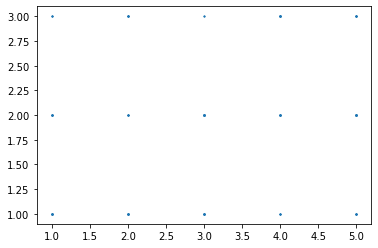

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df_sample = df_subset.sample(100)
#plt.scatter(df_subset["construction year scaled"].values, df_subset['price'].values, markersize=0.7)
#sns.kdeplot(data = df, x="x", y="y", cmap="Reds", shade=True)
plt.plot(df_sample["reviews_quintile"].values, df_sample['price_tertile'].values, "", data=df, linestyle='', marker='o', markersize=1)

print(df_subset)

In [14]:
#
#
#
# DECISION TREE
#
#
#

In [15]:
from sklearn import tree
from sklearn.model_selection import train_test_split

decision_tree_x = df_subset[['reviews_quintile', 'review rate number', 'construction year scaled']].values
decision_tree_y = df_subset['price_tertile'].values

X_train, X_test, y_train, y_test = train_test_split(decision_tree_x, decision_tree_y, test_size = 0.2, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

print("Accuracy: ", clf.score(X_test, y_test))

Accuracy:  0.35226928131001717
